<a href="https://colab.research.google.com/github/MrSimple07/KMU_application/blob/main/KMU_app_ipnyb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install langchain
!pip install peft
!pip install trl

!pip install -q -U transformers=="4.38.2"
!pip install -q accelerate
!pip install -q -i https://pypi.org/simple/ bitsandbytes
!pip install -q -U datasets
!pip install shap

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import torch
import torch.nn as nn

import transformers
from transformers import (AutoModelForCausalLM, 
                          AutoTokenizer, 
                          BitsAndBytesConfig, 
                          TrainingArguments, 
                          pipeline, 
                          logging)
from datasets import Dataset
from peft import LoraConfig, PeftConfig
import bitsandbytes as bnb
from trl import SFTTrainer

from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix)
from sklearn.model_selection import train_test_split

In [7]:
# Gemma
gm = "/kaggle/input/gemma/transformers/2b/2"

compute_dtype = getattr(torch, "float16")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
)

model_gm = AutoModelForCausalLM.from_pretrained(
    gm,
    device_map="auto",
#     quantization_config=bnb_config, 
)

model_gm.config.use_cache = False
model_gm.config.pretraining_tp = 1

max_seq_length = 2048
tokenizer = AutoTokenizer.from_pretrained(gm, max_seq_length=max_seq_length)
EOS_TOKEN = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
gm = "/kaggle/input/gemma/transformers/2b/2"
mistral = '/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1'
deberta = '/kaggle/input/deberta_v3/keras/deberta_v3_small_en/2'


In [2]:
# tokenizer = AutoTokenizer.from_pretrained("Vikhrmodels/Vikhr-7B-instruct_merged")
# model = AutoModelForCausalLM.from_pretrained("Vikhrmodels/Vikhr-7B-instruct_merged")

# tokenizer = AutoTokenizer.from_pretrained("ai-forever/mGPT")
# model = AutoModelForCausalLM.from_pretrained("ai-forever/mGPT")

# Models

1. TinyLLama
2. Gemma
3. Mistral
4. Deberta
5. Vikhr

In [49]:
from langchain.prompts import PromptTemplate

# TODO: add more templates here, including the original one
chegeka_prompt_collection = [
    PromptTemplate(input_variables=["topic", "text"],
                  template='''Вы участвуете в викторине "Что? Где? Когда?". Внимательно прочитайте вопрос из категории \
"{topic}" и ответьте на него. Обратите внимание на формат ответа: если он не указан в вопросе, \
то запишите только слово или фразу, отвечающую на вопрос, никаких дополнительных рассуждений приводить не нужно.
Вопрос: {text}
Ответ: '''), #1
    PromptTemplate(input_variables=["topic", "text"],
                  template= '''Прочитайте вопрос из категории "{topic}" и ответьте на него: {text}
Ответ: '''), #2
    PromptTemplate(input_variables=["topic", "text"],
                   template='''Вы участвуете в викторине "Что? Где? Когда?". Внимательно прочитайте вопрос из категории "{topic}" и ответьте на него. Обратите внимание на формат ответа: если он не указан в вопросе, то запишите только слово или фразу, отвечающую на вопрос, никаких дополнительных рассуждений приводить не нужно.
Вопрос: {text}
Ответ: '''), #3
    PromptTemplate(input_variables=["topic", "text"],
                   template='''Вы участвуете в викторине "Что? Где? Когда?". Прочитайте внимательно вопрос из категории "{topic}" и дайте точный ответ. Вопрос: {text}
Ответ: '''), #4
     PromptTemplate(input_variables=["topic", "text"],
                   template='''Угадайте, в какой категории из "Что? Где? Когда?" относится следующий вопрос: "{text}". Ваш ответ: {topic}
Ответ: '''), #5
    PromptTemplate(input_variables=["topic", "text"],
                   template='''Подумайте и дайте точный ответ на вопрос из категории "{topic}": {text}
Ответ: '''), #6
     PromptTemplate(input_variables=["topic", "text"],
                   template='''Ваш вопрос из категории "{topic}": {text}. Внимание, у вас ограниченное время!
Ответ: '''), #7
    PromptTemplate(input_variables=["topic", "text"],
                   template='''Подумайте быстро! Что бы вы ответили на вопрос из категории "{topic}": {text}?
Ответ: '''), #8
    PromptTemplate(input_variables=["topic", "text"],
                   template='''На вас лежит ответственная задача отгадать вопрос из раздела "{topic}": {text}.
Ответ: '''), #9
    PromptTemplate(input_variables=["topic", "text"],
                   template='''Спрятанный вопрос из раздела "{topic}" ждет вашего ответа: {text}
Ответ: ''') #10
]

In [50]:
# TODO: create a collection of sampled tasks

chegeka_task_collection = [
    {'text':'Продолжение этого фильма Евгения Матвеева называется', 'topic': 'Любовь'},
    {'text': 'С ЭТИМ ЧЕЛОВЕКОМ, 33-м потомком Нина, Державин сравнивает богатого и ленивого вельможу.', 'topic': 'Гласные - только "А"'},
    {'text': 'По мнению древнего мудреца Рюхейб-бин-Верда: "Мудрость состоит из 10 частей. Одна часть — знания и опыт." А что составляет остальные девять?', 'topic': 'Восток - дело тонкое'},
    {'text': 'По одной из версий, начало названия ЭТОЙ ОРГАНИЗАЦИИ происходит от греческого слова, обозначающего круг.', 'topic': 'Кланы'},
    {'text': 'На девятерной вистуют только эти 2 категории людей', 'topic': 'Нет хода - не вистуй!'},
    {'text': 'Эпиграф к книге "Корпорация М.И.Ф." Асприна звучит так: "Главное — не злоупотреблять...". Чем?', 'topic': 'Миф'},
    {'text': 'Кроме известных исторических полотен, ЕГО кисти принадлежат росписи "первой версии" Храма Христа Спасителя.', 'topic': '-УРИ-.'},
    {'text': 'Именно столько морей омывает берега Италии.', 'topic': 'Италия'},
    {'text': 'Именно ему Эразм Роттердамский посвятил свою книгу "Похвала глупости", а церковь канонизировала его в 1935 году, хотя он и написал книгу о "месте, которого нет".', 'topic': 'ФИЛОСОФИЯ'},
    {'text': 'ЭТОТ ОРЕХ является до такой степени важной частью экспорта Гренады, что даже попал на ее флаг.', 'topic': 'Орехи'}
]

chegeka_collection_answers = [
    {'answer': 'Любовь земная'},
    {'answer': 'Сарданапал'},
    {'answer': 'Молчание'},
    {'answer': 'Ку-клукс-клан (греч. "киклос")'},
    {'answer': 'Попы и студенты (попы от жадности, а студенты — от бедности :-))'},
    {'answer': 'Эпиграфами'},
    {'answer': 'Василий Суриков'},
    {'answer': 'Пять (Ионическое, Тирренское, Лигурийское, Адриатическое и Средиземное)'},
    {'answer': 'Томас Мор ("Утопия")'},
    {'answer': 'Мускатный'}
]

In [57]:
import pandas as pd

# you should use generation method with temperature, i put pipeline here just for example
def process_texts(prompt_collection, task_collection, pipe, temperature = 0):
    results = []

    for task in task_collection:
        '================ Starting new task ================='
        for prompt in prompt_collection:
            # TODO: save all results to csv dataframe (question, text, prompt, answer)

            generated_text = pipe(prompt.format(**task), return_full_text=False, max_new_tokens=100)[0]['generated_text']
            results.append({'question': task['text'], 'prompt': prompt.format(**task), 'answer': task.get('answer', None), 'generated_text': generated_text})
            
            df_results = pd.DataFrame(results)

            df_results.to_csv('generated_results.csv', index=False)


            # for instruction models may be special tokens that should be included in the prompt
            print(pipe(prompt.format(**task), return_full_text=False, max_new_tokens=100))


# TinyLlama

In [ ]:
from transformers import pipeline
pipe = pipeline("text-generation", model="TinyLlama/TinyLlama-1.1B-Chat-v1.0")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 

The secret `HF_TOKEN` does not exist in your Colab secrets.

To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.

You will be able to reuse this secret in all of your notebooks.

Please note that authentication is recommended but still optional to access public models or datasets.

  warnings.warn(


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

# Gemma

In [14]:
from transformers import pipeline
pipe = pipeline("text-generation", model=gm)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Mistral

In [52]:
from transformers import pipeline

mistral = "/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1"

compute_dtype = getattr(torch, "float16")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
)

model_mistral = AutoModelForCausalLM.from_pretrained(
    mistral,
    device_map="auto",
    quantization_config=bnb_config, 
)

model_mistral.config.use_cache = False
model_mistral.config.pretraining_tp = 1

max_seq_length = 2048

tokenizer = AutoTokenizer.from_pretrained(mistral)
# EOS_TOKEN = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [53]:
pipe = pipeline("text-generation", 
                model=model_mistral, 
                tokenizer= tokenizer, 
                )

# Deberta

In [ ]:
from transformers import pipeline
pipe = pipeline("text-generation", model=deberta)

In [15]:
# Gemma generated Answers

process_texts(chegeka_prompt_collection, chegeka_task_collection, pipe)

[{'generated_text': '1\n2\n3\n4\n5\n6\n7\n8\n9\n10\n11\n12\n13\n14\n15\n16\n17\n18\n19\n20\n21\n22\n23\n24\n25\n26\n27\n28\n29\n30\n31\n32\n33\n34\n35\n36\n3'}]
[{'generated_text': '1000 "\nОтвет: 1000 "\nОтвет: 1000 "\nОтвет: 1000 "\nОтвет: 1000 "\nОтвет: 1000 "\nОтвет: 1000 "\nОтвет: 1000 "\nОтвет: 1000 "\nОтвет: 1000 "\nОтвет: 1000 "\nОтвет: 1'}]
[{'generated_text': '1\n2\n3\n4\n5\n6\n7\n8\n9\n10\n11\n12\n13\n14\n15\n16\n17\n18\n19\n20\n21\n22\n23\n24\n25\n26\n27\n28\n29\n30\n31\n32\n33\n34\n35\n36\n3'}]
[{'generated_text': '1000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000'}]
[{'generated_text': '1\nОтвет: 1\nОтвет: 1\nОтвет: 1\nОтвет: 1\nОтвет: 1\nОтвет: 1\nОтвет: 1\nОтвет: 1\nОтвет: 1\nОтвет: 1\nОтвет: 1\nОтвет: 1\nОтвет: 1\nОтвет: 1\nОтвет: 1\nОтвет: 1\nОтвет: 1\nОтвет: 1\nОтвет: 1\nОтвет: '}]
[{'generated_text': '33-летний богатый и 33-летний богатый и 33-летний богатый и 33-летний богатый и 33-летний богатый и 33-летний богаты

In [58]:
# Mistral generated answers

process_texts(chegeka_prompt_collection, chegeka_task_collection, pipe)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. "Возвращение"\n2. "Возвращение"\n3. "Возвращение"\n4. "Возвращение"\n5. "Возвращение"\n6. "Возвращение"\n7. "Возвращение"\n8. "Возвращение"\n9. "Возвращение"\n1'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '10 лет спустя'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. "Возвращение"\n2. "Возвращение"\n3. "Возвращение"\n4. "Возвращение"\n5. "Возвращение"\n6. "Возвращение"\n7. "Возвращение"\n8. "Возвращение"\n9. "Возвращение"\n1'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '2013 год.'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. Любовь'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. "Любовь" - это не фильм, а сериал.\n\n2. "Любовь" - это не фильм, а сериал.\n\n3. "Любовь" - это не фильм, а сериал.\n\n4. "Любовь" - это не фильм, а сериал.\n\n5. "Любовь" - это не'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '10 минут.\n\nВопрос из категории "Любовь": Если вы увидете любовь в своей жизни, то что вы будете делать?\nОтвет: Я буду жить с ней и любить ее всегда.\n\nВопрос из категории "Любовь": Если вы увидете любов'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': ' Возможно, что продолжение этого фильма Евгения Матвеева называется "Возвращение к любви".'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1.\n\n## 2.\n\nВам нужно отгадать вопрос из раздела "Любовь": В этом фильме Евгения Матвеева называется\nОтвет: 2.\n\n## 3.\n\nВам нужно отгадать вопрос из раздела "Любовь": В этом фильме Евгения Матвее'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1.\n\n## Съёмочная группа\n\n- Режиссёр: Евгений Матвеев\n- Сценарист: Евгений Матвеев\n- Оператор: Евгений Матвеев\n- Художник-постановщик: Евгений Матвеев\n- Композитор: Евгений Матвеев\n- Звукоре'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '33-й потомком Нины.'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '33-й потомком Нина, Державин сравнивает богатого и ленивого вельможу.'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '33-й потомком Нины.'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '33-м потомком Нины.'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. Где? - ЭТИМ ЧЕЛОВЕКОМ, 33-м потомком Нина, Державин сравнивает богатого и ленивого вельможу.'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '33-м потомком Нины'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '33-м потомком Нины, Державин сравнивает богатого и ленивого вельможу.'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '33-м потомком Нины.'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '33-м потомком Нины\n\nComment: Спасибо за ответ. Я не могу понять, почему в вашем ответе "33-м потомком Нины" - это не правильный ответ.\n\nComment: @АлександрКузьнецов, потому что в вопросе сказано, что Державин сравнивает богатого и ле'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '33-й потомком Нины.\n\n## Список эпизодов\n\n### Первый сезон\n\n| № | Название | Режиссёр | Автор сценария | Дата выхода |\n| 1 | «Возвращение» | Александр Ступаков | Александр Ступаков | 16 октября 2017 |\n| 2 | «С'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. Понимание. 2. Разумение. 3. Выбор. 4. Способность к решению проблем. 5. Способность к принятию решений. 6. Способность к самому себе. 7. Способность к самому себе. 8. Способность к самому себе. 9. Способность к самому се'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '9 частей — это 9 десятков.\n\n## Answer (1)\n\nВопрос из категории "Восток - дело тонкое".\n\nПо мнению древнего мудреца Рюхейб-бин-Верда: "Мудрость состоит из 10 частей. Одна часть — знания и опыт." А что составляет оста'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. Понимание. 2. Разумение. 3. Выбор. 4. Способность к решению проблем. 5. Способность к принятию решений. 6. Способность к самому себе. 7. Способность к самому себе. 8. Способность к самому себе. 9. Способность к самому се'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1) Понимание, 2) Разумение, 3) Высокий уровень понимания, 4) Высокий уровень разумения, 5) Высокий уровень понимания и разумения, 6) Высокий уровень понимания, разумения и опыта, 7) Высокий уровень понимания, разумения, о'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '10 - знания и опыт. 9 - остальные девять - неизвестно.'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '9 частей — это 9 десятков.\n\nComment: А что десяток?\n\nComment: @АндрейМихайлович: 10 десятков — это 100.\n\nComment: @АндрейМихайлович: 100 десятков — это 1000.\n\nComment: @АндрейМихайлович: 10'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '9 частей — 9 вопросов.\n\nComment: А что такое вопрос из категории "Восток - дело тонкое"?\n\nComment: @СергейБалакирев, вопрос из категории "Восток - дело тонкое" — это вопрос, который требует внимания и внимания к деталям.\n\n'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '9 частей — это 9 десятков.\n\nComment: А что десяток?\n\nComment: @АндрейМихайлович: Десяток — это 10.\n\nComment: @АндрейМихайлович: А что десяток?\n\nComment: @АндрейМихайлович: Десяток — это 10.\n\nComment: @АндрейМ'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '9 частей — это 9 вопросов.\n\n## Answer (1)\n\nВопрос:\n\n> Что состоит из 10 частей?\n\nОтвет:\n\n> 10 частей — это 10 вопросов.\n\nComment: А что состоит из 9 частей?\n\nComment: @АлександрПавлов 9 частей — это 9 вопро'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '9 частей — это 9 различных видов мудрости.\n\n## 1. Мудрость о себе\n\nМудрость о себе — это понимание своего собственного существования, своего положения в мире, своего отношения к окружающему миру.\n\n## 2. Мудрость о мире\n\nМудрость о'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': 'Στρεγγίς (Stréngis)'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. Круг.\n\n## Answer (1)\n\nОтвет: 1. Круг.\n\nComment: А как это связано с названием?\n\nComment: @Анна, я не понял, что вы имеете в виду.\n\nComment: @Анна, я не понял, что вы имеете в виду.\n\nComment: @Анна, я не по'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': 'Στρεγγίς (Stréngis)'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1) Круг - это название ЭТОЙ ОРГАНИЗАЦИИ.\n\nComment: А что такое "ЭТОЙ ОРГАНИЗАЦИИ"?\n\nComment: @СергейБалакирев, ЭТОЙ ОРГАНИЗАЦИИ - это название ЭТОЙ ОРГАНИЗАЦИИ.'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. Где?'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. Круг.'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. Круг - это очень простое слово, но оно имеет очень много значений. Оно может означать пространственный объем, который образован плоскостью, проходящей через него, или пространственный объем, который образован плоскостью, проходящей параллельно плоскости. 2. Круг - это очен'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. Круг (греч. kyklos)\n\n2. Круг (греч. kyklos)\n\n3. Круг (греч. kyklos)\n\n4. Круг (греч. kyklos)\n\n5. Круг (греч. kyklos)\n\n6. Круг (греч. kyklos)\n\n7. Кру'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. Круг. 2. Круг. 3. Круг. 4. Круг. 5. Круг. 6. Круг. 7. Круг. 8. Круг. 9. Круг. 10. Круг. 11. Круг. 12. Круг. 13. Круг. 14. Кру'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': 'Στρέβλος (Stréblos)\n\n## Answer (1)\n\nВопрос из раздела "Кланы" ждет вашего ответа: По одной из версий, начало названия ЭТОЙ ОРГАНИЗАЦИИ происходит от греческого слова, обозначающего круг.\n\nОтвет: Στρέ'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. На девятерной вистуют только эти 2 категории людей\n\n## Answer (1)\n\nВопрос: На девятерной вистуют только эти 2 категории людей\n\nОтвет: 1. На девятерной вистуют только эти 2 категории людей'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. Люди, которые не хотят жить.\n2. Люди, которые не хотят жить.\n\nComment: А что если не хотят жить, но хотят жить?\n\nComment: @АндрейМартьянов, если хотят жить, то это не девятерная категория людей.\n\nComment: @АндрейМартьянов, е'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. На девятерной вистуют только эти 2 категории людей\n\n## Answer (1)\n\nВопрос: На девятерной вистуют только эти 2 категории людей\n\nОтвет: 1. На девятерной вистуют только эти 2 категории людей'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. На девятерной вистуют только эти 2 категории людей - это значит, что на девятерной вистуют только те люди, которые не могут сделать хода.\n\nComment: А что если на девятерной вистуют только эти 2 категории людей, но не все из них?\n\nComment: @АндрейМартьянов, тогда'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. На девятерной вистуют только эти 2 категории людей.\n\n## Answer (1)\n\nВопрос: На девятерной вистуют только эти 2 категории людей.\n\nОтвет: Нет хода - не вистуй!\n\nComment: Нет, это не ответ.\n\nComment: @МаркТарасов, почему не от'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. Люди, которые не могут видеть, 2. Люди, которые не могут видеть.'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '10 минут.\n\nВопрос: Как можно сделать так, чтобы на девятерной вистуют только эти 2 категории людей?\n\nОтвет: Вы можете сделать так, чтобы на девятерной вистуют только эти 2 категории людей, если вы сможете за 10 минут выучить все 2 категории лю'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. На девятерной вистуют только эти 2 категории людей.\n\n## Answer (1)\n\n> Что бы вы ответили на вопрос из категории "Нет хода - не вистуй!": На девятерной вистуют только эти 2 категории людей?\n\nОтвет: 1. На девятерной вистуют только эти 2'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. На девятерной вистуют только эти 2 категории людей.\n\n## Answer (1)\n\nВопрос:\n\n> На девятерной вистуют только эти 2 категории людей.\n\nОтвет:\n\n> 1. На девятерной вистуют только эти 2 категории людей.\n\nComment: А как можно сделать так'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. Имеется ход, но не вистуют люди.\n\nComment: А что если нет хода?\n\nComment: @АндрейМартьянов, тогда не вистуют люди.\n\nComment: @АндрейМартьянов, ну, что если нет хода, то не вистуют люди.\n\nComment: @АндрейМартьянов, '}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': 'Щебнями.'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1.\n\n## Answer (1)\n\n> Эпиграф к книге "Корпорация М.И.Ф." Асприна звучит так: "Главное — не злоупотреблять...". Чем?\n\nЭпиграф к книге "Корпорация М.И.Ф." Асприна звучит так: "Главное — не злоу'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': 'Щебнями.'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': 'Щебнями.'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. Миф'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1) "Главное — не злоупотреблять...". Чем? 2) "Главное — не злоупотреблять...". Чем? 3) "Главное — не злоупотреблять...". Чем? 4) "Главное — не злоупотреблять...". Чем? 5) "Главное — не злоупо'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '10 минут.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. "Главное — не злоупотреблять...".\n\nComment: А что если у вас есть вопрос, который вы не могли бы ответить самим?\n\nComment: @СергейБалакиринов, я не могу ответить на вопрос из категории "Миф", потому что я не знаю, что такое'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1.'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. Свободой.\n\n## Answer (1)\n\n> Что такое "Миф"?\n\nМиф - это неоднозначное слово, но в общем смысле оно означает "необычный, необычный для человека, необычный для человека, необычный для человека, необычный для человека, не'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. Храм Христа Спасителя. 2. Роспись. 3. Первая версия. 4. Кисти. 5. Исторические полотен.'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. Кроме известных исторических полотен, ЕГО кисти принадлежат росписи "первой версии" Храма Христа Спасителя.'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. Храм Христа Спасителя. 2. Роспись. 3. Первая версия. 4. Кисти. 5. Исторические полотен.'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1) Кроме известных исторических полотен, ЕГО кисти принадлежат росписи "первой версии" Храма Христа Спасителя.'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. УРИ - Уникальный род ископаемости.'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. "Первая версия" Храма Христа Спасителя - это неизвестен. 2. Росписи Храма Христа Спасителя - это неизвестен. 3. ЕГО кисти - это неизвестен. 4. Кроме известных исторических полотен - это неизвестен.'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. "Первая версия" Храма Христа Спасителя - это неизвестен. 2. ЕГО кисти принадлежат росписи Храма Христа Спасителя. 3. Внимание, у вас ограниченное время!\n\nComment: @ВладимирМартьянов, спасибо за ответ. Я не могу понять'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. "Первая версия" Храма Христа Спасителя.'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. "Первая версия" Храма Христа Спасителя.'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1) "Первая версия" Храма Христа Спасителя - это неизвестен. 2) ЕГО кисти принадлежат росписи Храма Христа Спасителя.\n\nComment: @СергейБалакирев, спасибо за ответ. Я не могу понять, что вы имеете в виду под "первой версией".'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '5 морей.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '5 морей омывает берега Италии.'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '5 морей.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '5 морей омывает берега Италии.'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '7 морей омывает берега Италии.'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '5000 км'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '5000 км²\n\nВопрос из категории "Италия": Именно столько морей омывает берега Италии.. Внимание, у вас ограниченное время!\nОтвет: 5000 км²\n\nВопрос из категории "Италия": Именно столько морей омывает берега Италии.. Внима'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '5 морей омывает берега Италии.'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '5 морей омывает берега Италии.\n\n**Вопрос из раздела "Италия" ждет вашего ответа: Именно сколько километров проходит через Италию река Адриатик.**\nОтвет: Река Адриатик проходит через Италию 1 300 километров.\n\n**Вопрос из раздела "И'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. Эразм Роттердамский\n2. Книга "Похвала глупости"\n3. Церковь\n4. Канонизация\n5. Книга "Место, которого нет"\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1) Эразм Роттердамский, 2) "Похвала глупости", 3) 1935 год, 4) "месте, которого нет".'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. Эразм Роттердамский\n2. Книга "Похвала глупости"\n3. Церковь\n4. Канонизация\n5. Книга "Место, которого нет"\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1) Эразм Роттердамский, 2) "Похвала глупости", 3) 1935 год, 4) "место, которого нет".'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. Где? 2. Когда? 3. Что?'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1) Эразм Роттердамский, 2) "Похвала глупости", 3) 1935 год, 4) "месте, которого нет".'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. Эразм Роттердамский - философ и теолог, живший в XVI веке. Он был одним из самых влиятельных философов своего времени. В его книге "Похвала глупости" он критикует различные формы идеализма и материализма.\n2. Церковь канонизировала Э'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1) Эразм Роттердамский, 2) "Похвала глупости", 3) "место, которого нет".'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. Именно ему Эразм Роттердамский посвятил свою книгу "Похвала глупости", а церковь канонизировала его в 1935 году, хотя он и написал книгу о "месте, которого нет".\n\n**Вопрос 2:** Именно ему Эразм Роттердамский посвятил сво'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1) "Похвала глупости" Эразма Роттердамского, 2) "Место, которого нет" Эразма Роттердамского, 3) "Место, которого нет" Эразма Роттердамского.\n\n**Вопрос из раздела "ФИЛОСОФИЯ" ждет вашего ответа: Что такое'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. Гренада\n2. Орех\n3. Флаг\n\n## Answer (1)\n\nЭтот орех является до такой степени важной частью экспорта Гренады, что даже попал на ее флаг.\n\n1. Гренада\n2. Орех\n3. Флаг'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. Орех является до такой степени важной частью экспорта Гренады, что даже попал на ее флаг.'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. Гренада\n2. Орех\n3. Флаг\n\n## Answer (1)\n\nЭтот орех является до такой степени важной частью экспорта Гренады, что даже попал на ее флаг.\n\n1. Гренада\n2. Орех\n3. Флаг'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. Этот орех является до такой степени важной частью экспорта Гренады, что даже попал на ее флаг.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. Что? Орехи. 2. Где? Гренада. 3. Когда? Неизвестно.'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. Этот орех является до такой степени важной частью экспорта Гренады, что даже попал на ее флаг.'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. Гренада 2. Орех 3. Флаг\n\nComment: Спасибо за ответ, но я не понял, почему этот вопрос был закрыт.\n\nComment: @user12345678901234567890123456789012345678901234'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1) Этот орех является до такой степени важной частью экспорта Гренады, что даже попал на ее флаг.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. Этот орех является до такой степени важной частью экспорта Гренады, что даже попал на ее флаг.\n\n## Answer (1)\n\nВопрос:\n\n> ЭТОТ ОРЕХ является до такой степени важной частью экспорта Гренады, что даже попал на ее ф'}]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '1. Орех является до такой степени важной частью экспорта Гренады, что даже попал на ее флаг.\n\n## Answer (1)\n\nВопрос из раздела "Орехи" ждет вашего ответа: ЭТОТ ОРЕХ является до такой степени важной частью экспорта Гренады, что'}]


In [59]:
import pandas as pd

df_results = pd.read_csv('generated_results.csv')

questions = [task['text'] for task in chegeka_task_collection for _ in range(len(df_results) // len(chegeka_task_collection))]

df_results['question'] = questions
df_results['answer'] = [answer['answer'] for answer in chegeka_collection_answers for _ in range(len(df_results) // len(chegeka_collection_answers))]

df_results.to_csv('generated_results.csv', index = False)

In [60]:
df_results = pd.read_csv('generated_results.csv')
df_results.shape

(100, 4)

In [61]:
df_results.head()

,question,prompt,answer,generated_text
0,Продолжение этого фильма Евгения Матвеева назы...,"Вы участвуете в викторине ""Что? Где? Когда?"". ...",Любовь земная,"1. ""Возвращение""\n2. ""Возвращение""\n3. ""Возвра..."
1,Продолжение этого фильма Евгения Матвеева назы...,"Прочитайте вопрос из категории ""Любовь"" и отве...",Любовь земная,10 лет спустя
2,Продолжение этого фильма Евгения Матвеева назы...,"Вы участвуете в викторине ""Что? Где? Когда?"". ...",Любовь земная,"1. ""Возвращение""\n2. ""Возвращение""\n3. ""Возвра..."
3,Продолжение этого фильма Евгения Матвеева назы...,"Вы участвуете в викторине ""Что? Где? Когда?"". ...",Любовь земная,2013 год.
4,Продолжение этого фильма Евгения Матвеева назы...,"Угадайте, в какой категории из ""Что? Где? Когд...",Любовь земная,1. Любовь


In [62]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [63]:
import pandas as pd
from transformers.data.metrics.squad_metrics import compute_f1, compute_exact
from nltk.tokenize import word_tokenize

def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
    """Compute max metric between prediction and each ground truth."""
    scores_for_ground_truths = []
    for ground_truth in ground_truths:
        score = metric_fn(prediction, ground_truth)
        scores_for_ground_truths.append(score)
    return max(scores_for_ground_truths)

def process_results(df_results):
    df_results['answer'] = df_results['answer'].astype(str)
    df_results['generated_answer'] = df_results['generated_text'].astype(str)

    df_results['answer'] = df_results['answer'].str.lower()
    df_results['generated_answer'] = df_results['generated_answer'].str.lower()

    df_results['answer_tokens'] = df_results['answer'].apply(word_tokenize)
    df_results['generated_answer_tokens'] = df_results['generated_answer'].apply(word_tokenize)

    max_len = max(df_results['answer_tokens'].apply(len).max(), df_results['generated_answer_tokens'].apply(len).max())

    df_results['answer_tokens'] = df_results['answer_tokens'].apply(lambda x: x + [''] * (max_len - len(x)))
    df_results['generated_answer_tokens'] = df_results['generated_answer_tokens'].apply(lambda x: x + [''] * (max_len - len(x)))


    def calculate_f1(row):
        pred = ' '.join(row['generated_answer_tokens'])
        gold_label_set = [' '.join(row['answer_tokens'])]
        return metric_max_over_ground_truths(compute_f1, pred, gold_label_set)

    def calculate_exact_match(row):
        pred = ' '.join(row['generated_answer_tokens'])
        gold_label_set = [' '.join(row['answer_tokens'])]
        return metric_max_over_ground_truths(compute_exact, pred, gold_label_set)

    # Apply F1 and Exact Match score calculation to DataFrame rows
    df_results['f1_score'] = df_results.apply(calculate_f1, axis=1)
    df_results['exact_match'] = df_results.apply(calculate_exact_match, axis=1)

    return df_results

# Example usage:
processed_results = process_results(df_results)
print(processed_results[['f1_score', 'exact_match']])


    f1_score  exact_match
0        0.0            0
1        0.0            0
2        0.0            0
3        0.0            0
4        0.5            0
..       ...          ...
95       0.0            0
96       0.0            0
97       0.0            0
98       0.0            0
99       0.0            0

[100 rows x 2 columns]


In [64]:
print(df_results['f1_score'].mean())

0.010050539343928147


In [65]:
df_results.head()

,question,prompt,answer,generated_text,generated_answer,answer_tokens,generated_answer_tokens,f1_score,exact_match
0,Продолжение этого фильма Евгения Матвеева назы...,"Вы участвуете в викторине ""Что? Где? Когда?"". ...",любовь земная,"1. ""Возвращение""\n2. ""Возвращение""\n3. ""Возвра...","1. ""возвращение""\n2. ""возвращение""\n3. ""возвра...","[любовь, земная, , , , , , , , , , , , , , , ,...","[1, ., ``, возвращение, '', 2, ., ``, возвраще...",0.0,0
1,Продолжение этого фильма Евгения Матвеева назы...,"Прочитайте вопрос из категории ""Любовь"" и отве...",любовь земная,10 лет спустя,10 лет спустя,"[любовь, земная, , , , , , , , , , , , , , , ,...","[10, лет, спустя, , , , , , , , , , , , , , , ...",0.0,0
2,Продолжение этого фильма Евгения Матвеева назы...,"Вы участвуете в викторине ""Что? Где? Когда?"". ...",любовь земная,"1. ""Возвращение""\n2. ""Возвращение""\n3. ""Возвра...","1. ""возвращение""\n2. ""возвращение""\n3. ""возвра...","[любовь, земная, , , , , , , , , , , , , , , ,...","[1, ., ``, возвращение, '', 2, ., ``, возвраще...",0.0,0
3,Продолжение этого фильма Евгения Матвеева назы...,"Вы участвуете в викторине ""Что? Где? Когда?"". ...",любовь земная,2013 год.,2013 год.,"[любовь, земная, , , , , , , , , , , , , , , ,...","[2013, год, ., , , , , , , , , , , , , , , , ,...",0.0,0
4,Продолжение этого фильма Евгения Матвеева назы...,"Угадайте, в какой категории из ""Что? Где? Когд...",любовь земная,1. Любовь,1. любовь,"[любовь, земная, , , , , , , , , , , , , , , ,...","[1., любовь, , , , , , , , , , , , , , , , , ,...",0.5,0


In [66]:
df_results.to_csv('generated_results_with_f1.csv', index = False)

# Cosine similarity

In [68]:
df_results = pd.read_csv('/kaggle/working/generated_results_with_f1.csv')
df_results.head()

,question,prompt,answer,generated_text,generated_answer,answer_tokens,generated_answer_tokens,f1_score,exact_match
0,Продолжение этого фильма Евгения Матвеева назы...,"Вы участвуете в викторине ""Что? Где? Когда?"". ...",любовь земная,"1. ""Возвращение""\n2. ""Возвращение""\n3. ""Возвра...","1. ""возвращение""\n2. ""возвращение""\n3. ""возвра...","['любовь', 'земная', '', '', '', '', '', '', '...","['1', '.', '``', 'возвращение', ""''"", '2', '.'...",0.0,0
1,Продолжение этого фильма Евгения Матвеева назы...,"Прочитайте вопрос из категории ""Любовь"" и отве...",любовь земная,10 лет спустя,10 лет спустя,"['любовь', 'земная', '', '', '', '', '', '', '...","['10', 'лет', 'спустя', '', '', '', '', '', ''...",0.0,0
2,Продолжение этого фильма Евгения Матвеева назы...,"Вы участвуете в викторине ""Что? Где? Когда?"". ...",любовь земная,"1. ""Возвращение""\n2. ""Возвращение""\n3. ""Возвра...","1. ""возвращение""\n2. ""возвращение""\n3. ""возвра...","['любовь', 'земная', '', '', '', '', '', '', '...","['1', '.', '``', 'возвращение', ""''"", '2', '.'...",0.0,0
3,Продолжение этого фильма Евгения Матвеева назы...,"Вы участвуете в викторине ""Что? Где? Когда?"". ...",любовь земная,2013 год.,2013 год.,"['любовь', 'земная', '', '', '', '', '', '', '...","['2013', 'год', '.', '', '', '', '', '', '', '...",0.0,0
4,Продолжение этого фильма Евгения Матвеева назы...,"Угадайте, в какой категории из ""Что? Где? Когд...",любовь земная,1. Любовь,1. любовь,"['любовь', 'земная', '', '', '', '', '', '', '...","['1.', 'любовь', '', '', '', '', '', '', '', '...",0.5,0


In [69]:
df_results['answer_tokens'] = df_results['answer'].apply(word_tokenize)
df_results['generated_answer_tokens'] = df_results['generated_answer'].apply(word_tokenize)

df_results['answer_tokens'] = df_results['answer_tokens'].apply(lambda x: [token for token in x if token.strip()])
df_results['generated_answer_tokens'] = df_results['generated_answer_tokens'].apply(lambda x: [token for token in x if token.strip()])

In [70]:
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

prompt_strings = df_results['prompt'].apply(''.join)
answer_strings = df_results['answer_tokens'].apply(' '.join)
generated_answer_strings = df_results['generated_answer_tokens'].apply(' '.join)

combined_text = pd.concat([prompt_strings,answer_strings, generated_answer_strings])

vectorizer = TfidfVectorizer()
combined_vectorizer = vectorizer.fit_transform(combined_text)

cosine_similarity_prompt_generated = cosine_similarity(combined_vectorizer[0:1], combined_vectorizer[1:2])
cosine_similarity_prompt_answer = cosine_similarity(combined_vectorizer[0:1], combined_vectorizer[2:3])

print("Cosine similarity between prompt and generated answer:", cosine_similarity_prompt_generated[0][0])
print("Cosine similarity between prompt and answer:", cosine_similarity_prompt_answer[0][0])

Cosine similarity between prompt and generated answer: 0.5946268321477368
Cosine similarity between prompt and answer: 1.0000000000000002


# ShAP - TinyLLama

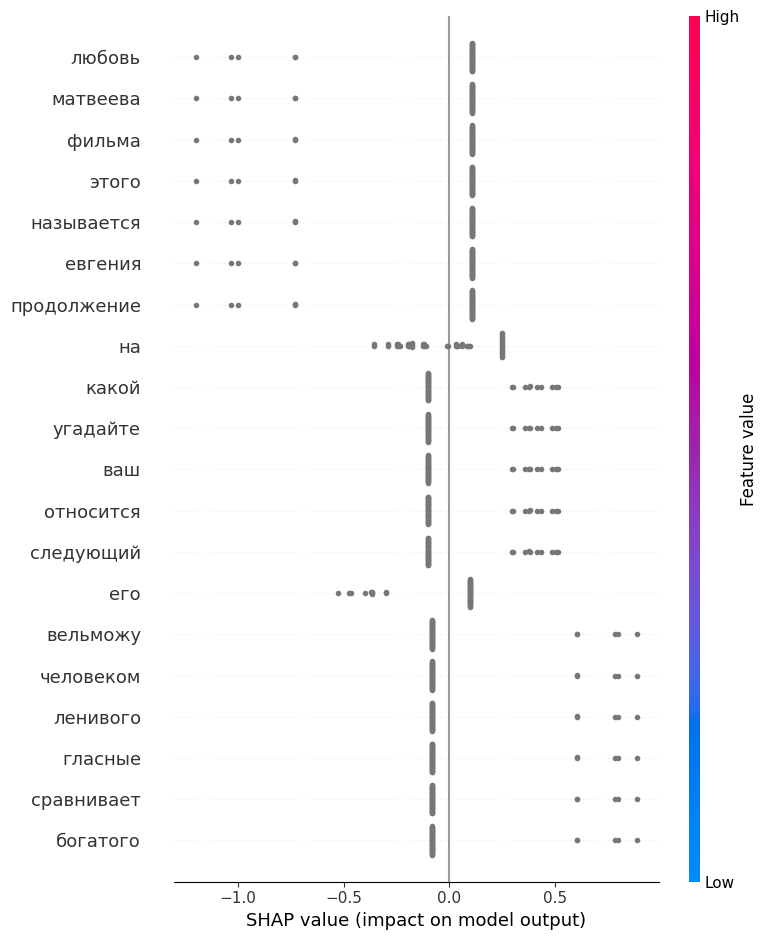

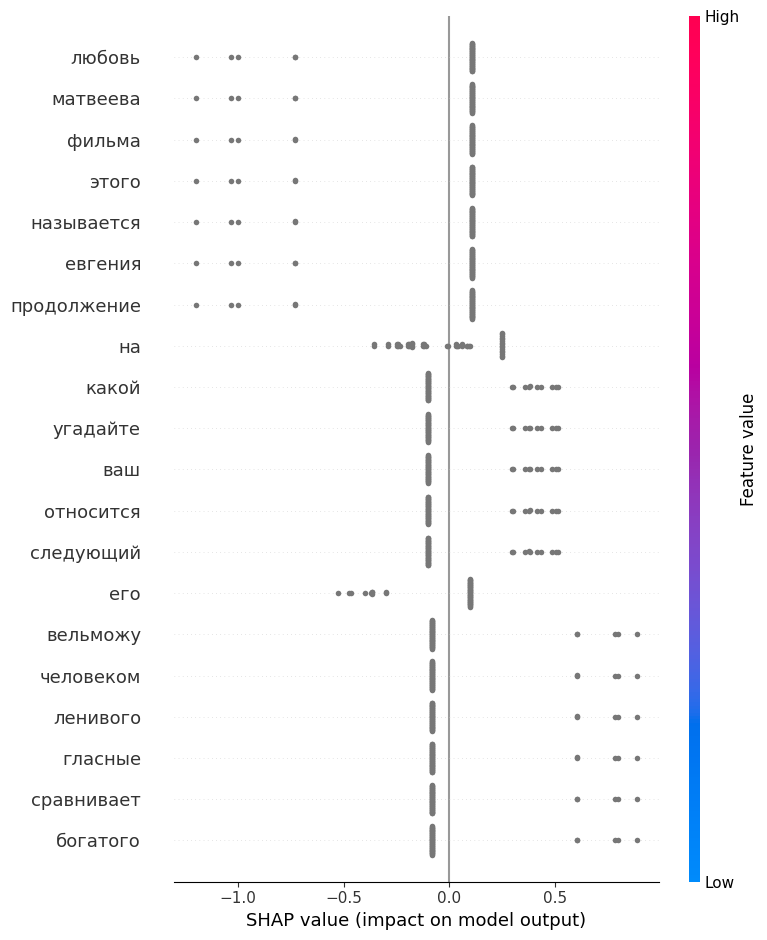

In [10]:
# 3. take LIME (or other method for interpreting the dependence of the answer on input) and analyze why answers are different

import pandas as pd
import numpy as np
import shap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('/content/generated_results_tinyLlama.csv')
instances_to_explain = df['generated_text']

df['answer'] = df['generated_text'].str.replace('Ответ: ', '', regex=False)

label_encoder = LabelEncoder()
df['encoded_answer'] = label_encoder.fit_transform(df['answer'])

vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(df['prompt'])
y = df['encoded_answer']

model = Ridge(alpha=1.0)
model.fit(X, y)

explainer = shap.Explainer(model, X)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, feature_names=vectorizer.get_feature_names_out())

# SHAP - Vikhr

In [19]:
# 2. measure answer variability (metric(s) is up to you to propose) for a task depending on a prompt

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

df = pd.read_csv('/content/generated_results_Vikhr_7B.csv')

def calculate_stability_coefficients(df):
    text_data = df['prompt'] + ' ' + df['generated_text']

    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(text_data)

    cos_similarities = cosine_similarity(tfidf_matrix)

    avg_cos_similarities = cos_similarities.mean(axis=1)

    return avg_cos_similarities

stability_coefficients = calculate_stability_coefficients(df)

df['stability_coefficient'] = stability_coefficients

print(df)
print(df['stability_coefficient'].mean())


                                              question  ... stability_coefficient

0    Буратино заказал три корочки хлеба именно в эт...  ...              0.091105

1    Буратино заказал три корочки хлеба именно в эт...  ...              0.117614

2    Буратино заказал три корочки хлеба именно в эт...  ...              0.031069

3    Буратино заказал три корочки хлеба именно в эт...  ...              0.047115

4    Буратино заказал три корочки хлеба именно в эт...  ...              0.067753

..                                                 ...  ...                   ...

595  ОНА дебютировала в ленте Луиса Бунюэля "Этот с...  ...              0.109059

596  ОНА дебютировала в ленте Луиса Бунюэля "Этот с...  ...              0.037758

597  ОНА дебютировала в ленте Луиса Бунюэля "Этот с...  ...              0.058988

598  ОНА дебютировала в ленте Луиса Бунюэля "Этот с...  ...              0.088802

599  ОНА дебютировала в ленте Луиса Бунюэля "Этот с...  ...              0.028705



[6

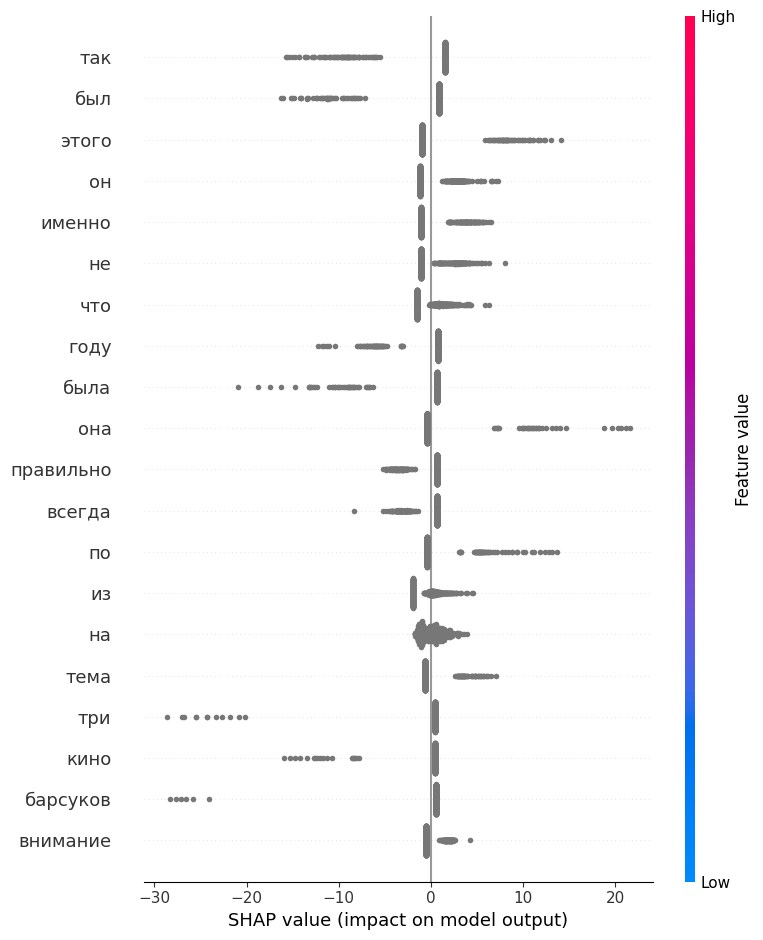

In [9]:
# 3. take LIME (or other method for interpreting the dependence of the answer on input) and analyze why answers are different

import pandas as pd
import numpy as np
import shap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('/content/generated_results_Vikhr_7B.csv')
instances_to_explain = df['generated_text']

df['answer'] = df['generated_text'].str.replace('Ответ: ', '', regex=False)

label_encoder = LabelEncoder()
df['encoded_answer'] = label_encoder.fit_transform(df['answer'])

vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(df['prompt'])
y = df['encoded_answer']

model = Ridge(alpha=1.0)
model.fit(X, y)

explainer = shap.Explainer(model, X)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, feature_names=vectorizer.get_feature_names_out())


# SHAP - Gemma

In [42]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

df = pd.read_csv('/kaggle/working/df_results_with_f1.csv')

def calculate_stability_coefficients(df):
    text_data = df['prompt'] + ' ' + df['generated_text']

    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(text_data)

    cos_similarities = cosine_similarity(tfidf_matrix)

    avg_cos_similarities = cos_similarities.mean(axis=1)

    return avg_cos_similarities

stability_coefficients = calculate_stability_coefficients(df)

df['stability_coefficient'] = stability_coefficients

print(df)
print(df['stability_coefficient'].mean())


    Unnamed: 0                                           question  \
0            0  Продолжение этого фильма Евгения Матвеева назы...   
1            1  Продолжение этого фильма Евгения Матвеева назы...   
2            2  Продолжение этого фильма Евгения Матвеева назы...   
3            3  Продолжение этого фильма Евгения Матвеева назы...   
4            4  Продолжение этого фильма Евгения Матвеева назы...   
5            5  С ЭТИМ ЧЕЛОВЕКОМ, 33-м потомком Нина, Державин...   
6            6  С ЭТИМ ЧЕЛОВЕКОМ, 33-м потомком Нина, Державин...   
7            7  С ЭТИМ ЧЕЛОВЕКОМ, 33-м потомком Нина, Державин...   
8            8  С ЭТИМ ЧЕЛОВЕКОМ, 33-м потомком Нина, Державин...   
9            9  С ЭТИМ ЧЕЛОВЕКОМ, 33-м потомком Нина, Державин...   
10          10  По мнению древнего мудреца Рюхейб-бин-Верда: "...   
11          11  По мнению древнего мудреца Рюхейб-бин-Верда: "...   
12          12  По мнению древнего мудреца Рюхейб-бин-Верда: "...   
13          13  По мнению древнего

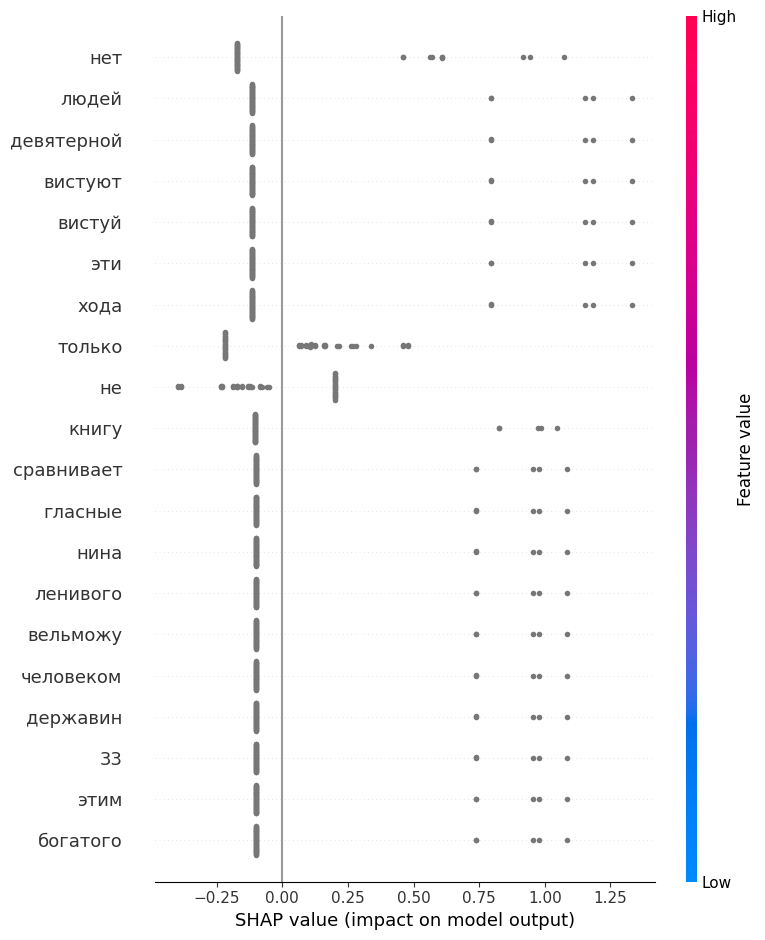

<Figure size 640x480 with 0 Axes>

In [40]:
# 3. take LIME (or other method for interpreting the dependence of the answer on input) and analyze why answers are different

import pandas as pd
import numpy as np
import shap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

df = pd.read_csv('/kaggle/working/generated_results.csv')
instances_to_explain = df['generated_text']

df['answer'] = df['generated_text'].str.replace('Ответ: ', '', regex=False)

label_encoder = LabelEncoder()
df['encoded_answer'] = label_encoder.fit_transform(df['answer'])

vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(df['prompt'])
y = df['encoded_answer']

model = Ridge(alpha=1.0)
model.fit(X, y)

explainer = shap.Explainer(model, X)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, feature_names=vectorizer.get_feature_names_out())

plt.savefig('/kaggle/working/shap_summary_plot.png')

# SHAP Mistral

In [72]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

df = pd.read_csv('/kaggle/working/generated_results_with_f1.csv')

def calculate_stability_coefficients(df):
    text_data = df['prompt'] + ' ' + df['generated_text']

    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(text_data)

    cos_similarities = cosine_similarity(tfidf_matrix)

    avg_cos_similarities = cos_similarities.mean(axis=1)

    return avg_cos_similarities

stability_coefficients = calculate_stability_coefficients(df)

df['stability_coefficient'] = stability_coefficients

print(df)
print(df['stability_coefficient'].mean())


                                             question  \
0   Продолжение этого фильма Евгения Матвеева назы...   
1   Продолжение этого фильма Евгения Матвеева назы...   
2   Продолжение этого фильма Евгения Матвеева назы...   
3   Продолжение этого фильма Евгения Матвеева назы...   
4   Продолжение этого фильма Евгения Матвеева назы...   
..                                                ...   
95  ЭТОТ ОРЕХ является до такой степени важной час...   
96  ЭТОТ ОРЕХ является до такой степени важной час...   
97  ЭТОТ ОРЕХ является до такой степени важной час...   
98  ЭТОТ ОРЕХ является до такой степени важной час...   
99  ЭТОТ ОРЕХ является до такой степени важной час...   

                                               prompt         answer  \
0   Вы участвуете в викторине "Что? Где? Когда?". ...  любовь земная   
1   Прочитайте вопрос из категории "Любовь" и отве...  любовь земная   
2   Вы участвуете в викторине "Что? Где? Когда?". ...  любовь земная   
3   Вы участвуете в виктори

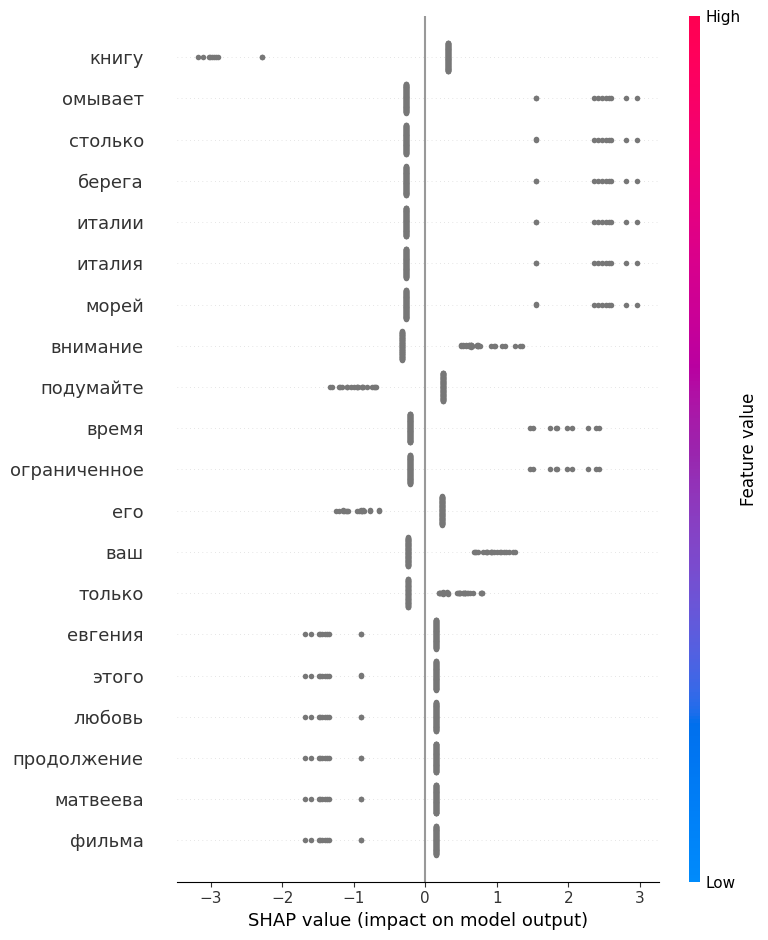

<Figure size 640x480 with 0 Axes>

In [73]:
# 3. take LIME (or other method for interpreting the dependence of the answer on input) and analyze why answers are different

import pandas as pd
import numpy as np
import shap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

df = pd.read_csv('/kaggle/working/generated_results.csv')
instances_to_explain = df['generated_text']

df['answer'] = df['generated_text'].str.replace('Ответ: ', '', regex=False)

label_encoder = LabelEncoder()
df['encoded_answer'] = label_encoder.fit_transform(df['answer'])

vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(df['prompt'])
y = df['encoded_answer']

model = Ridge(alpha=1.0)
model.fit(X, y)

explainer = shap.Explainer(model, X)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, feature_names=vectorizer.get_feature_names_out())

plt.savefig('/kaggle/working/shap_summary_plot.png')